# Forecasting Time Series Part II: Predicting Stock, Forex, Cryptocurrency Prices with 95%

First of all, this is not one of those predicting tutorials using linear regression and etc. I'm going to show you the mistakes and how to chose a correct model. I am not going to use any machine learning or AI models. This one uses pure statistics. No fancy equations here! I will keep it as simple as i can.

# Most common mistakes!

Let me ask you a question. What is predicting? Simply, it is guessing something. And how can one say that AI can predict future prices? Do you think it is possible?

Well yes and no! In reality, even a child can predict stock prices. For example if i go and ask to my 5 years old, how much will bitcoin reach tomorrow, she will "never" say "i don't know". Though she doesn't have any clue what bitcoin is.

Machine learning and AI models are the same! They give you an output and you believe it. What would you expecting? Did you see any models that tells you "I have no idea!"?! Well yes it's not that easy but at least i am refering the models you are watching on YouTube!

And have you ever noticed that the prices given are "VERY" close to the opening prices? And do you know why? Because there is ~50% probability that the closing price will be lower than the opening price and ~50% probability will be higher than the opening price. So the best thing to do is to find a price near the opening price of the bar.

Here i will show you my own prediction method without using any AI or ML models but statistics.

# Stop trying to predict the closing price!

I don't know why people focused so much on predicting closing prices. In reality, to win a trade, we don't need to know closing price. Instead, you can predict winning probability of your trade which is quite easy! However, if you still want to go for it, you can take a look at my previous article here: https://medium.com/@atillayurtseven/forecasting-time-series-part-i-predict-stock-forex-and-cryptocurrency-prices-using-statistical-2e2b67ba917d

In this article, I'm going to show you how can you predict a price 95% at a time.

Let's begin!

Disclaimer: All the information in this article, including the algorithm, was provided and published for informational purposes only and should not be considered legal or financial advice.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy import stats
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
def load_db(file):
    fix_price = lambda x: float(str(x).replace(',',''))
    df = pd.read_csv(file)
    # clean data
    if 'Price' in df.columns:
        df.rename(columns={"Price":"Close"}, inplace=True)
    cols = []
    if 'Change %' in df.columns:
        cols.append('Change %')
    if 'Vol.' in df.columns:
        cols.append('Vol.')
    df.drop(cols, axis=1, inplace=True)
    try:
        df['Date'] = pd.to_datetime(df['Date'], format="%b %d, %Y")
    except:
        df['Date'] = pd.to_datetime(df['Date'])
    df['Open'] = df['Open'].apply(fix_price)
    df['High'] = df['High'].apply(fix_price)
    df['Low'] = df['Low'].apply(fix_price)
    df['Close'] = df['Close'].apply(fix_price)
    # This is the tricky part!!!
    # Calculate how far did price go from Open for each day!
    df['MaxHigh'] = df['High']/df['Open']
    df['MaxLow'] = df['Low']/df['Open']
    df['MaxClose'] = df['Close']/df['Open']
    # I will use prices beginning 2014
    return df[df['Date']>='2014-01-01']

In [3]:
# In this article, I am using GBPUSD
sym = "GBP_USD"
period = "1d"
file = "./{} {}.csv".format(period, sym)

In [4]:
db = load_db(file).reset_index(drop=True)
db.tail()

,Date,Close,Open,High,Low,MaxHigh,MaxLow,MaxClose
1213,2018-08-12,1.2760,1.2751,1.2780,1.2744,1.002274,0.999451,1.000706
1214,2018-08-13,1.2768,1.2768,1.2793,1.2729,1.001958,0.996945,1.000000
1215,2018-08-14,1.2725,1.2771,1.2827,1.2704,1.004385,0.994754,0.996398
1216,2018-08-15,1.2693,1.2717,1.2735,1.2662,1.001415,0.995675,0.998113
1217,2018-08-16,1.2707,1.2694,1.2733,1.2687,1.003072,0.999449,1.001024


In [5]:
def show_min_max(df):
    # find max and min values for High
    max_high = (df['MaxHigh'].max()-1)*100
    min_high = (df['MaxHigh'].min()-1)*100

    # find max and min values for Low
    max_low = (df['MaxLow'].max()-1)*100
    min_low = (df['MaxLow'].min()-1)*100

    # find max and min values for Close
    max_close = (df['MaxClose'].max()-1)*100
    min_close = (df['MaxClose'].min()-1)*100

    print("OpenToHigh\nMax: {:.2f}%\nMin: {:.2f}%\n".format(max_high, min_high))
    print("OpenToLow\nMax: {:.2f}%\nMin: {:.2f}%\n".format(max_low, min_low))
    print("OpenToClose\nMax: {:.2f}%\nMin: {:.2f}%\n".format(max_close, min_close))

In [6]:
show_min_max(db)

OpenToHigh
Max: 3.08%
Min: -0.05%

OpenToLow
Max: 0.00%
Min: -11.07%

OpenToClose
Max: 3.06%
Min: -8.02%



Since the beginning of our data, GBPUSD increased Maximum of 3.08% in a day and dropped maximum of 11.07% (Brexit?) a day. Also, GBPUSD closed the day with maximum 3.06% of gains and maximum 8.02% loses

Actually there are some outliers and i am going to clean them!

In [7]:
def drop_outliers(df, col, perc=75):
    # perc: 75 is the most common one for droping outliers!
    q1 = df[col].quantile((100-perc)/100)
    q3 = df[col].quantile(perc/100)
    iqr = q3-q1 #Interquartile range
    l = q1-1.5*iqr
    u = q3+1.5*iqr
    return df[(df[col]>l) & (df[col]<u)]

In [8]:
before_ol = len(db)
# I want to keep my original data as it is!
df = drop_outliers(db, 'MaxHigh')
df = drop_outliers(df, 'MaxLow')
df = drop_outliers(df, 'MaxClose')
show_min_max(df)
after_ol = len(df)
print("Before cleaning: {}\nAfter cleaning: {}".format(before_ol, after_ol))

OpenToHigh
Max: 1.12%
Min: -0.05%

OpenToLow
Max: 0.00%
Min: -1.21%

OpenToClose
Max: 1.03%
Min: -1.10%

Before cleaning: 1218
After cleaning: 1125


In [9]:
# define probability that we are interested in
# I have chosen 95% but you can change it. Less probability increases the profit
prb = 95

In [10]:
def prob(df, col, p):
    # I'm using percentile here
    lp = np.percentile(df[col].dropna(), p)
    fig, ax = plt.subplots(figsize=(20,10))
    plt.plot_date(df['Date'], df[col], ls='-', fmt='')
    ax.xaxis.set_tick_params(rotation=30, labelsize=10)
    ax.axhline(lp, color='r')
    return lp

Open Price: 1.26940
Prediction: 1.26998
Probability: 95%
Ticks: 0.00058
Monthly Ticks: 0.01279 (127 pips)


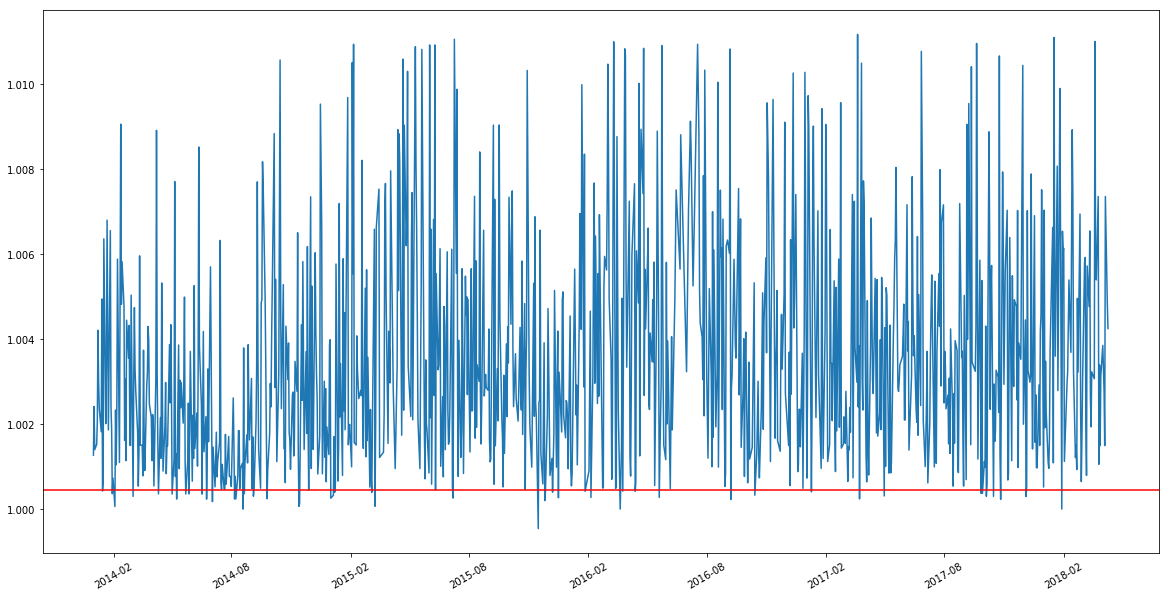

In [11]:
col = 'MaxHigh' # Let's find 75% of High (100-prb)
days = 100 # This is the testing size. So we will test last 100 days and exclude them from the calculation.
p = prob(df[:-days], col, 100-prb)
# get the current bar's open price
open_price = df['Open'].iloc[-1]
prediction = open_price * p
ticks = abs(open_price-(p*open_price))
monthly = 22 * ticks # 22 trading days in a month
mp = int(monthly / 0.0001)
print("Open Price: {:.5f}\nPrediction: {:.5f}\nProbability: {}%\nTicks: {:.5f}\nMonthly Ticks: {:.5f} ({} pips)".format(open_price, prediction, prb, ticks, monthly, mp))

If you open a Long trade with 5-6 pips target price, you will win 95% of your trades. Let's backtest it with an unseen data!

In [12]:
# Create a prediction column for each day and multiply it with the value we have got from out model.
d = df[-days:] # get unseen data from our dataset
# p: value we have got from out model
d['HighPredicts'] = d['Open'] * p
total = len(d)
# if the High price of the day cross over our prediction, we will win!!!
won = len(d[d['High']>d['HighPredicts']])
hit_rate = won*100/total
print("Hit rate {:.2f}% of {} trades!".format(hit_rate, total))

Hit rate 96.00% of 100 trades!


What a hit!!! It's more than 95% of win rate!

Please note that as you increase your win rate, your profit drops. Of course! Because we have used percentile with historical data and a large look back period.

Now let's try the same for short positions. Let's predict Low of the day using same function but a different calculation this time!

Open Price: 1.26940
Prediction: 1.26880
Probability: 95%
Ticks: 0.00060
Monthly Ticks: 0.01316 (131 pips)


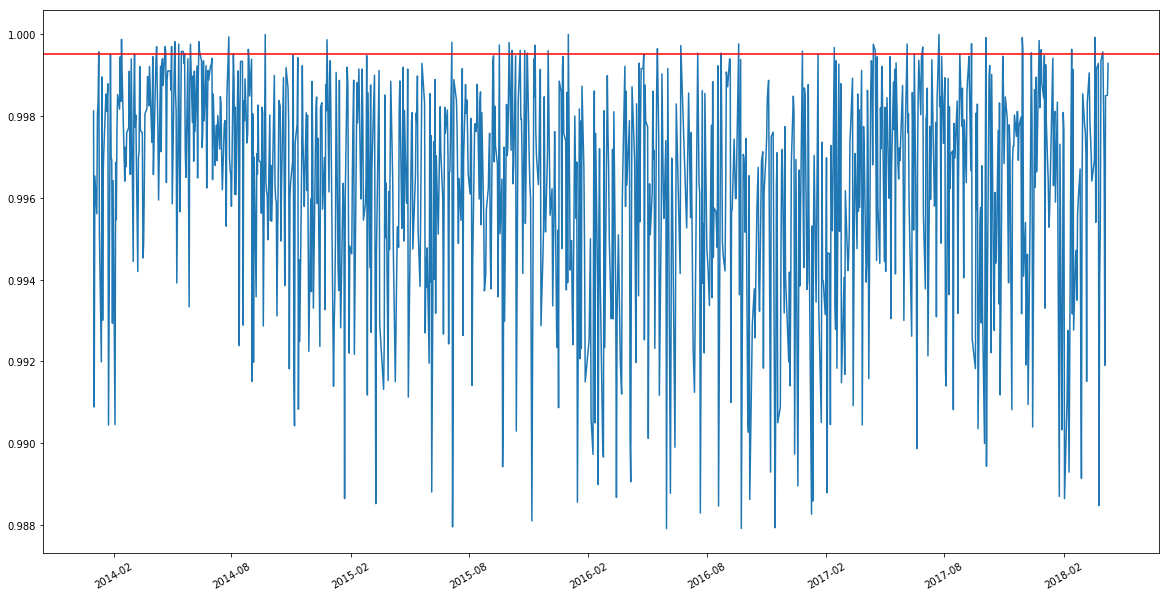

In [13]:
col = 'MaxLow' # Let's find 75% of Low but this time we will just use prb instead of 100-prb
p = prob(df[:-days], col, prb)
# get the current bar's open price
open_price = df['Open'].iloc[-1]
prediction = open_price * p
ticks = abs(open_price-(p*open_price))
monthly = 22 * ticks
mp = int(monthly / 0.0001)
print("Open Price: {:.5f}\nPrediction: {:.5f}\nProbability: {}%\nTicks: {:.5f}\nMonthly Ticks: {:.5f} ({} pips)".format(open_price, prediction, prb, ticks, monthly, mp))

Graph shows us that 95% of price will be over the red line. It's 60 ticks (6 pips) per day

In [14]:
# Create a prediction column for each day
d = df[-days:]
d['LowPredicts'] = d['Open'] * p
total = len(d)
# if Low of the day cross under our prediction, we will win!!!
won = len(d[d['Low']<d['LowPredicts']])
hit_rate = won*100/total
print("Hit rate {:.2f}% of {} trades!".format(hit_rate, total))

Hit rate 92.00% of 100 trades!


Another great hit!!! It's 92% but sounds great for an unseen data isn't it?

Ok now we have found 95% high and low ranges. Finally let's calculate the closing price range instead of High/Low to see if there is a difference!

I am going to use the same function!

Open Price: 1.26940
Prediction: 1.26901 - 1.26973
Probability: 95%
Low ticks: 0.00039
High ticks: 0.00033


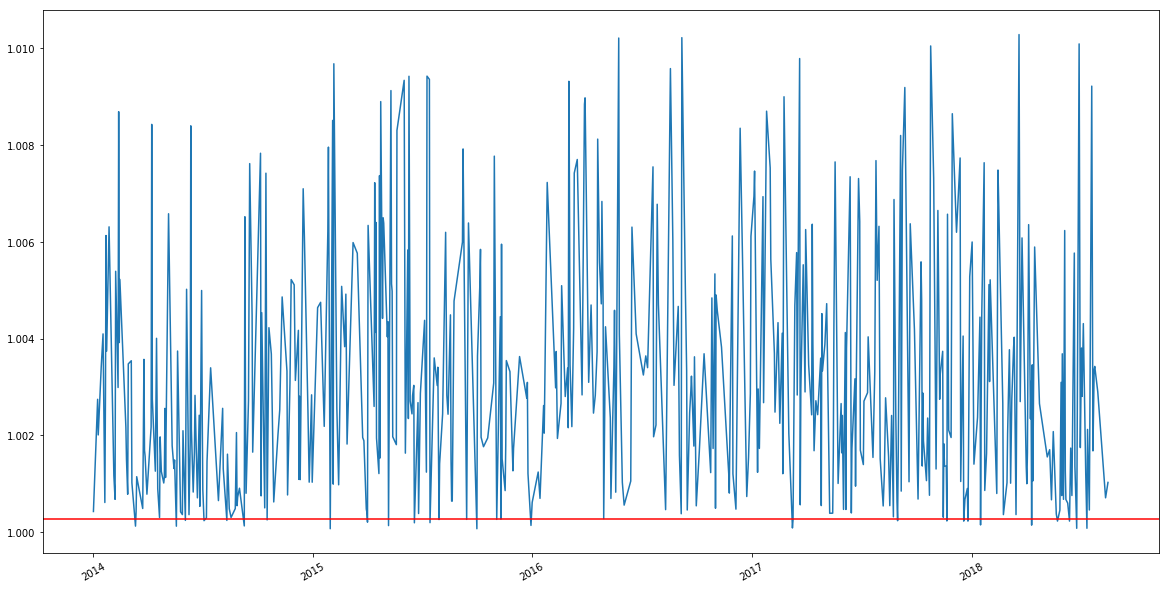

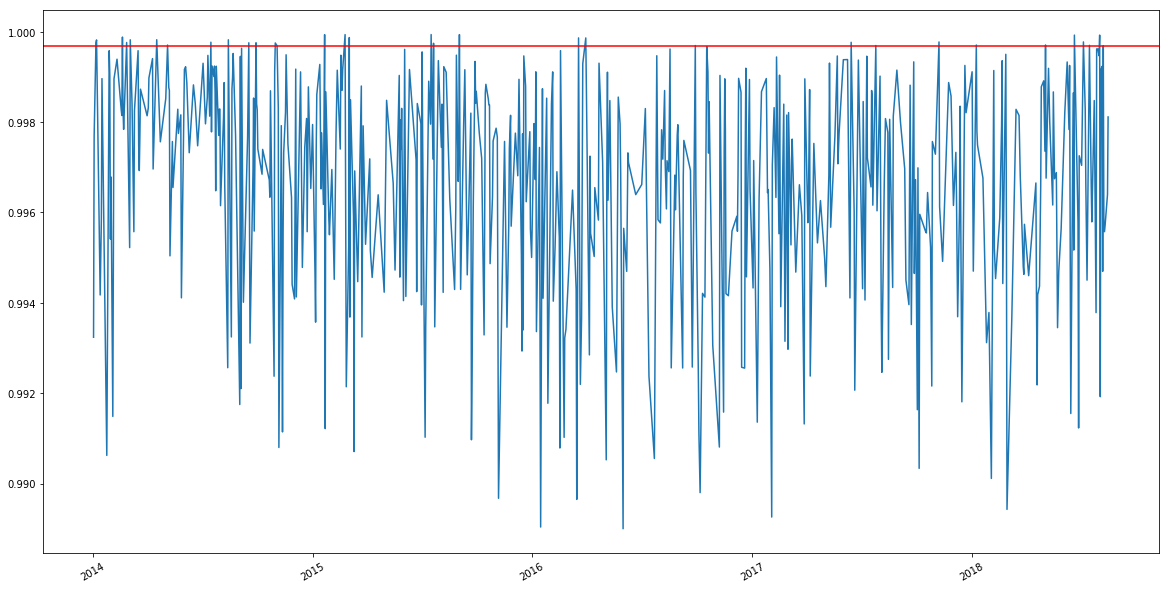

In [15]:
col = 'MaxClose' # Let's find 75% of Low but this time we will just use prb instead of 100-prb
max_close = prob(df[df['MaxClose']>1], col, 100-prb) # only for green bars
min_close = prob(df[df['MaxClose']<1], col, prb) # only for red bars
# get the current bar's open price
open_price = df['Open'].iloc[-1]
prediction_max = open_price * max_close
prediction_min = open_price * min_close
print("Open Price: {:.5f}\nPrediction: {:.5f} - {:.5f}\nProbability: {}%".format(open_price, prediction_min, prediction_max, prb))                                             
print("Low ticks: {:.5f}".format(open_price-prediction_min))
print("High ticks: {:.5f}".format(prediction_max-open_price))

Ok this is interesting! Because when we predicted 95% for High and Low, the ticks were more than Closing price. So why do we have to use closing price in this case?

Let's backtest them and to see if we can get the same results!

In [16]:
# Create a prediction column for each day
d = df[-days:]
d['CloseLowPredicts'] = d['Open'] * min_close
d['CloseHighPredicts'] = d['Open'] * max_close
total = len(d)

# We are predicting a level we can make money. In this article, we are not trying to predict actual closing price
# That's why we are going to try to take profit!

# if Low of the day cross under our prediction, we will win!!!
low_won = len(d[d['Low']<d['CloseLowPredicts']])

# if High of the day cross over our prediction, we will win!!!
high_won = len(d[d['High']>d['CloseHighPredicts']])
low_hit_rate = low_won*100/total
high_hit_rate = high_won*100/total
print("Hit rate {:.2f}% for Low - {:.2f}% for High".format(low_hit_rate, high_hit_rate))

Hit rate 94.00% for Low - 98.00% for High


Hit rate is almost same! But the ticks we won is more than we won by predicting closing price!

# What is next?

You can give extra features to the model to achieve higher ticks. For example you can add two moving averages for long and short. Let's try it and see if we can get higher ticks.

In [17]:
def prob_ma(df, col, p, is_low=False):
    # I'm using percentile here
    df['MA1'] = df['Close'].rolling(5).mean()
    df['MA2'] = df['Close'].rolling(220).mean()
    if is_low:
        cond = df['MA2']>df['MA1']
    else:
        cond = df['MA1']>df['MA2']
    lp = np.percentile(df[col][cond].dropna(), p)
    return lp, len(df[col][cond].dropna())

In [18]:
col = 'MaxHigh' # Let's find 75% of High (100-prb)
days = 100 # This is the testing size. So we will test last 100 days and exclude them from the calculation.
p, trades = prob_ma(df[:-days], col, 100-prb)
# get the current bar's open price
open_price = df['Open'].iloc[-1]
prediction = open_price * p
ticks = abs(open_price-(p*open_price))
monthly = 22 * ticks # 22 trading days in a month
mp = int(monthly / 0.0001)
print("Trades: {}/{}\nOpen Price: {:.5f}\nPrediction: {:.5f}\nProbability: {}%\nTicks: {:.5f}\nMonthly Ticks: {:.5f} ({} pips)".format(trades, len(df[:-days]), open_price, prediction, prb, ticks, monthly, mp))

Trades: 286/1025
Open Price: 1.26940
Prediction: 1.27023
Probability: 95%
Ticks: 0.00083
Monthly Ticks: 0.01833 (183 pips)


As you can see, we have increased our winning ticks but note that we have only entered 286 trades out of 1025 days! You can use different filters to find the optimum value!

# Conclusion

Looks like instead of predicting Closing prices, we should better predict High/Low. Because they give more ticks with great hit rate!

I have used the word "predict" most of the times. But this is not predicting. This is simply statistics and calculating probability using statistical methods.

In my next article, I'm going to show you how to calculate your winning probability using statistical methods!

Remember to follow me on

Twitter: https://twitter.com/atillayurtseven

Medium: http://medium.com/@atillayurtseven/

TradingView: https://www.tradingview.com/u/Dumani/